In [1]:
%load_ext autoreload
%autoreload 2

import fastai
from fastai import *
from fastai.vision import *

In [2]:
fastai.__version__

'1.0.58.dev0'

In [3]:
lesson_dir_path = Path('/home/blaberj/fastai_course/lesson5-sgd-mnist')

In [4]:
with gzip.open(lesson_dir_path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [5]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

In [6]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [7]:
class mnist_single(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb):
        return self.lin(xb)

In [8]:
class mnist_double(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 200, bias=True)
        self.bn1  = nn.BatchNorm1d(200)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(200,  10, bias=True)

    def forward(self, xb):
        yb = self.lin1(xb)
        yb = self.bn1(yb)
        yb = self.relu(yb)
        yb = self.lin2(yb)
        return yb

### Try manually

In [9]:
def update(model, x, y, lr, wd):    
    # Get model loss
    y_hat = model(x)
    l_m = nn.functional.cross_entropy(y_hat, y)
    
    # Get weight decay loss
    l_wd = 0
    for p in model.parameters():
        l_wd += (p**2).sum()
    l_wd = wd*l_wd
    
    # Get total loss
    l_t = l_m + l_wd
    
    # Update
    l_t.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return (l_t.item(), l_m.item(), l_wd.item())

In [10]:
lr = 3e-2
wd = 1e-2
model = mnist_single().cuda()
losses = [update(model, x, y, lr, wd) for x,y in data.train_dl]

(0, 2.5)

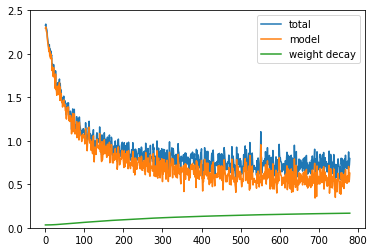

In [11]:
plt.plot([l[0] for l in losses], label='total')
plt.plot([l[1] for l in losses], label='model')
plt.plot([l[2] for l in losses], label='weight decay')
plt.legend();
plt.ylim(0, 2.5)

In [12]:
lr = 3e-2
wd = 1e-3
model = mnist_double().cuda()
losses = [update(model, x, y, lr, wd) for x,y in data.train_dl]

(0, 2.5)

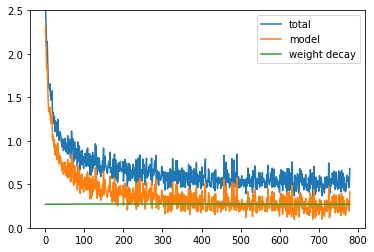

In [13]:
plt.plot([l[0] for l in losses], label='total')
plt.plot([l[1] for l in losses], label='model')
plt.plot([l[2] for l in losses], label='weight decay')
plt.legend();
plt.ylim(0, 2.5)

### Use ADAM

In [14]:
def update(model, x, y, lr):    
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    l = nn.functional.cross_entropy(y_hat, y)
    l.backward()
    opt.step()
    opt.zero_grad()
    return l.item()

In [15]:
lr = 1e-3
model = mnist_double().cuda()
losses = [update(model, x, y, lr) for x,y in data.train_dl]

(0, 2.5)

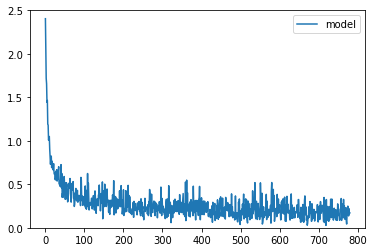

In [16]:
plt.plot(losses, label='model')
plt.legend();
plt.ylim(0, 2.5)

### Use learner

In [17]:
learn = Learner(data,
                mnist_double(),
                loss_func=nn.functional.cross_entropy,
                metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


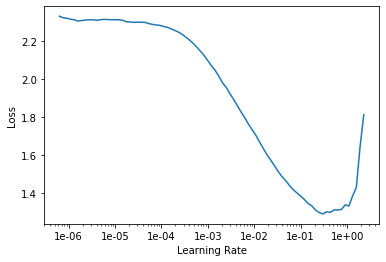

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
lr = 1e-2
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.188405,0.143952,0.957400,00:02
1,0.131604,0.117434,0.966100,00:02
2,0.118110,0.098222,0.970200,00:02
3,0.088729,0.095426,0.971100,00:02
4,0.063498,0.079735,0.975100,00:02
5,0.047052,0.075538,0.978700,00:02
6,0.029050,0.072094,0.981000,00:02
7,0.014337,0.063264,0.982700,00:02
8,0.008036,0.063386,0.983900,00:02
9,0.004270,0.063041,0.983900,00:02


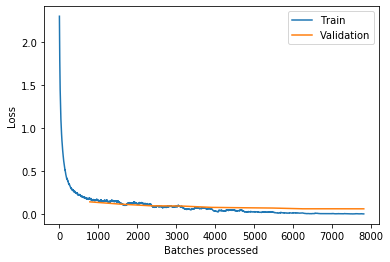

In [20]:
learn.recorder.plot_losses()